<div class="alert alert-block alert-success">
    <h1 align="center">Robotics project</h1>
    <h3 align="center">Analyzing 6-DOF UR10 robot arm</h3>
</div>

<div>
<img src="./img/ur10_1.jpg" width="400" height="200"/>
</div>

## Import libraries

In [2]:
from sympy import *
import numpy as np
import math
from math import degrees

## Part1
### Forward Kinematics

In [122]:
# Define the symbolic variables
num_symbols = 6  # Number of symbols to generate
alpha_names = [f"alpha{i}" for i in range(num_symbols+1)]
a_names = [f"a{i}" for i in range(num_symbols+1)]
d_names = [f"d{i}" for i in range(num_symbols+1)]
theta_names = [f"theta{i}" for i in range(num_symbols+1)]

alpha = symbols(alpha_names)
a = symbols(a_names)
d = symbols(d_names)
theta = symbols(theta_names)

# Define DH table
DH_param = [[0, 0, d[1], theta[1]],
            [pi/2, 0, 0, theta[2]],
            [0, a[2], 0, theta[3]],
            [0, a[3], d[4], theta[4]],
            [-pi/2, 0, d[5], theta[5]],
            [pi/2, 0, d[6], theta[6]]]

# find homogeneous transformations(T_i_i-1)                
T = []
for i in range(6):
    T_temp = [[cos(DH_param[i][3]), -sin(DH_param[i][3]), 0, DH_param[i][1]],
              [sin(DH_param[i][3])*cos(DH_param[i][0]),  cos(DH_param[i][3])*cos(DH_param[i][0]), -sin(DH_param[i][0]), -sin(DH_param[i][0])*(DH_param[i][2])],
              [sin(DH_param[i][3])*sin(DH_param[i][0]), cos(DH_param[i][3])*sin(DH_param[i][0]), cos(DH_param[i][0]), cos(DH_param[i][0])*DH_param[i][2]],
              [0, 0, 0, 1]]
    T.append(T_temp)

# print homogeneous transformations(T_i_i-1)
for i in range(len(T)):
    print('T_',i,'_',i+1,' :\n')
    pprint(Matrix(np.array(T[i])))
    print()


T_ 0 _ 1  :

⎡cos(θ₁)  -sin(θ₁)  0  0 ⎤
⎢                        ⎥
⎢sin(θ₁)  cos(θ₁)   0  0 ⎥
⎢                        ⎥
⎢   0        0      1  d₁⎥
⎢                        ⎥
⎣   0        0      0  1 ⎦

T_ 1 _ 2  :

⎡cos(θ₂)  -sin(θ₂)  0   0⎤
⎢                        ⎥
⎢   0        0      -1  0⎥
⎢                        ⎥
⎢sin(θ₂)  cos(θ₂)   0   0⎥
⎢                        ⎥
⎣   0        0      0   1⎦

T_ 2 _ 3  :

⎡cos(θ₃)  -sin(θ₃)  0  a₂⎤
⎢                        ⎥
⎢sin(θ₃)  cos(θ₃)   0  0 ⎥
⎢                        ⎥
⎢   0        0      1  0 ⎥
⎢                        ⎥
⎣   0        0      0  1 ⎦

T_ 3 _ 4  :

⎡cos(θ₄)  -sin(θ₄)  0  a₃⎤
⎢                        ⎥
⎢sin(θ₄)  cos(θ₄)   0  0 ⎥
⎢                        ⎥
⎢   0        0      1  d₄⎥
⎢                        ⎥
⎣   0        0      0  1 ⎦

T_ 4 _ 5  :

⎡cos(θ₅)   -sin(θ₅)  0  0 ⎤
⎢                         ⎥
⎢   0         0      1  d₅⎥
⎢                         ⎥
⎢-sin(θ₅)  -cos(θ₅)  0  0 ⎥
⎢                         ⎥
⎣   0  

In [123]:
# find T_0_6 and print it
result = T[0]
for n in range(1,len(T)):
    # Multiply the matrices
    result = [[sum(result[i][k] * T[n][k][j] for k in range(4)) for j in range(4)] for i in range(4)]
# Simplify the result according to cosine multiplication rules
simplified_result = [[trigsimp(expr) for expr in row] for row in result]

# Print the simplified result
print('T_0_6 : ')
Matrix(np.array(simplified_result))

T_0_6 : 


Matrix([
[(-sin(theta1)*sin(theta5) + cos(theta1)*cos(theta5)*cos(theta2 + theta3 + theta4))*cos(theta6) - sin(theta6)*sin(theta2 + theta3 + theta4)*cos(theta1), -(-sin(theta1)*sin(theta5) + cos(theta1)*cos(theta5)*cos(theta2 + theta3 + theta4))*sin(theta6) - sin(theta2 + theta3 + theta4)*cos(theta1)*cos(theta6), sin(theta1)*cos(theta5) + sin(theta5)*cos(theta1)*cos(theta2 + theta3 + theta4),  a2*cos(theta1)*cos(theta2) + a3*cos(theta1)*cos(theta2 + theta3) + d4*sin(theta1) - d5*sin(theta2 + theta3 + theta4)*cos(theta1) + d6*(sin(theta1)*cos(theta5) + sin(theta5)*cos(theta1)*cos(theta2 + theta3 + theta4))],
[ (sin(theta1)*cos(theta5)*cos(theta2 + theta3 + theta4) + sin(theta5)*cos(theta1))*cos(theta6) - sin(theta1)*sin(theta6)*sin(theta2 + theta3 + theta4),  -(sin(theta1)*cos(theta5)*cos(theta2 + theta3 + theta4) + sin(theta5)*cos(theta1))*sin(theta6) - sin(theta1)*sin(theta2 + theta3 + theta4)*cos(theta6), sin(theta1)*sin(theta5)*cos(theta2 + theta3 + theta4) - cos(theta1)*cos(theta5)

In [124]:
def forward(theta):
    DH = [[0, 0, 0.128, theta[0]],
          [pi/2, 0, 0, theta[1]],
          [0, 0.6129, 0, theta[2]],
          [0, 0.5716, 0.1639, theta[3]],
          [-pi/2, 0, 0.1157, theta[4]],
          [pi/2, 0, 0.0922, theta[5]]]
    # find homogeneous transformations(T_i_i-1)                
    T = []
    for i in range(6):
        T_temp = [[cos(DH_param[i][3]), -sin(DH_param[i][3]), 0, DH_param[i][1]],
              [sin(DH_param[i][3])*cos(DH_param[i][0]),  cos(DH_param[i][3])*cos(DH_param[i][0]), -sin(DH_param[i][0]), -sin(DH_param[i][0])*(DH_param[i][2])],
              [sin(DH_param[i][3])*sin(DH_param[i][0]), cos(DH_param[i][3])*sin(DH_param[i][0]), cos(DH_param[i][0]), cos(DH_param[i][0])*DH_param[i][2]],
              [0, 0, 0, 1]]
        T.append(T_temp)
        
    # find T_0_6 and print it
    result = T[0]
    for n in range(1,len(T)):
        # Multiply the matrices
        result = [[sum(result[i][k] * T[n][k][j] for k in range(4)) for j in range(4)] for i in range(4)]
    #T_res = np.array(T[0])@np.array(T[1])@np.array(T[2])@np.array(T[3])@np.array(T[4])@np.array(T[5])
    return result

In [112]:
def forward_version2(theta):
    theta1, theta2, theta3, theta4, theta5, theta6 = theta
    FK = Matrix(np.array(simplified_result)).subs({'d1':0.128, 'd4': 0.1639, 'd5':0.1157, 'd6':0.0922, 'a2':0.6129, 'a3':0.5716,
                                             'theta1':theta1, 'theta2':theta2, 'theta3':theta3, 'theta4':theta4, 
                                              'theta5':theta5, 'theta6':theta6})
    return np.array(FK).tolist()

## Part2
### Inverse Kinematics

In [125]:
def inverse(T):
    # define DH table
    DH = [[0, 0, 0.128, theta[0]],
          [pi/2, 0, 0, theta[1]],
          [0, 0.6129, 0, theta[2]],
          [0, 0.5716, 0.1639, theta[3]],
          [-pi/2, 0, 0.1157, theta[4]],
          [pi/2, 0, 0.0922, theta[5]]]
    
    # define theta database
    theta_db = []
    
    # define variables for each element of T
    [[r11, r12, r13, px],
     [r21, r22, r23, py],
     [r31, r32, r33, pz]] = T[0:3]
    
    # step1)find theta1
    a = py-DH[5][2]*r23
    b = DH[5][2]*r13-px
    c = -DH[3][2]
    theta_db.append(2*math.atan((b+math.sqrt(b**2+a**2-c**2))/(a+c)))
    theta_db.append(2*math.atan((b-math.sqrt(b**2+a**2-c**2))/(a+c)))
    
    # step2)find theta5
    theta_temp = []
    for theta1 in theta_db:
        c5 = r13*math.sin(theta1)-r23*math.cos(theta1)
        s5 = [math.sqrt(1-(c5)**2),-math.sqrt(1-(c5)**2)]
        theta_temp.append([theta1,math.atan2(s5[0],c5)])
        theta_temp.append([theta1,math.atan2(s5[1],c5)])
    theta_db = theta_temp   
    
    # step3) find theta2+theta3+theta4
    theta_temp = []
    flag = []
    for theta_list in theta_db:
        theta1 = theta_list[0]
        theta5 = theta_list[1]
        theta234 = []
        if round(theta5,4) == 0:
            gamma = math.atan2(r31, r32)
            Q1 = r31
            Q2 = r11*math.cos(theta1) + r21*math.sin(theta1)
            b = Q1*math.sin(gamma) + Q2*math.cos(gamma) - 1
            a = Q2*math.sin(gamma) - Q1*math.cos(gamma)
            theta234 = [2*math.atan((b+math.sqrt(b**2+a**2))/a), 2*math.atan((b-math.sqrt(b**2+a**2))/a)]
            flag.append('0')
            flag.append('0')
        elif round(theta5,4) == pi or round(theta5,4) == -pi:
            gamma_prim = math.atan2(-r31, r32)
            Q1 = r31
            Q2 = r11*math.cos(theta1) + r21*math.sin(theta1)
            b_prim = Q1*math.sin(gamma_prim) - Q2*math.cos(gamma_prim) - 1
            a_prim = Q2*math.sin(gamma_prim) + Q1*math.cos(gamma_prim)
            theta234 = [2*math.atan((b_prim+math.sqrt(b_prim**2+a_prim**2))/a_prim), 2*math.atan((b_prim-math.sqrt(b_prim**2+a_prim**2))/a_prim)]
            flag.append('180')
            flag.append('180')
        else:
            #c234 = (r13-math.sin(theta1)*math.cos(theta5))/(math.sin(theta5)*math.cos(theta1))
            s234 = r33/math.sin(theta5)
            c234 = [math.sqrt(1-s234**2), -math.sqrt(1-s234**2)]
            theta234 = [math.atan2(s234,c234[0]), math.atan2(s234,c234[1])]
            flag.append('ok')
            flag.append('ok')
        theta_temp.append([theta1, theta5, theta234[0]])      
        theta_temp.append([theta1, theta5, theta234[1]])
        
    theta_db = theta_temp 

    # step4) find theta6
    theta_temp = []
    i = 0
    for theta_list in theta_db:
        theta1, theta5, theta234 = theta_list
        theta6 = None
        if flag[i] == '0':
            gamma = math.atan2(r31, r32)
            theta6 = gamma - theta234
        elif flag[i] == '180':
            gamma_prim = math.atan2(-r31, r32)
            theta6 = theta234 - gamma_prim
        else:
            k1, k2 = math.cos(theta234), math.sin(theta234)*math.cos(theta5)
            theta6 = math.atan2(r31,r32)-math.atan2(k2,k1)
        theta_temp.append([theta1, theta5, theta234, theta6])
        i+=1
    theta_db = theta_temp
    
    # step5) find theta3, theta2, theta4
    theta_temp = []
    i=0
    for theta_list in theta_db:
        theta1, theta5, theta234, theta6 = theta_list        
        
        d1, d4, d5, d6 = DH[0][2], DH[3][2], DH[4][2], DH[5][2]
        a2, a3 = DH[2][1], DH[3][1]
        if round(theta1,4) == 0 or round(theta1,4) == pi or round(theta1,4) == -pi:
            F1 = -d5*math.sin(theta234)*math.cos(theta1)+d6*math.sin(theta5)*math.cos(theta1)*math.cos(theta234)
            F2 = d1+d5*math.cos(theta234)+d6*math.sin(theta5)*math.sin(theta234)
            X = (px - F1)/math.cos(theta1)
            Z = pz - F2
            # 5_1) find theta3
            c3 = (X**2 + Z**2 - a2**2 - a3**2)/(2*a2*a3)
            s3 = [math.sqrt(1-c3**2), -math.sqrt(1-c3**2)]
            theta_3_list = [math.atan2(s3[0], c3), math.atan2(s3[1], c3)]
            # 5_2) find theta2 and theta4
            for theta3 in theta_3_list:
                Q1 = a2 + a3*math.cos(theta3)
                Q2 = a3*math.sin(theta3)
                theta2 = math.atan2(Z,X) - math.atan2(Q2, Q1)
                theta4 = theta234 - theta3 - theta2
                theta_temp.append([theta1, theta2, theta3, theta4, theta5, theta6])
        else:
            F2 = (py+d4*math.cos(theta1)+d5*math.sin(theta234)*math.sin(theta1)+d6*(math.cos(theta1)*math.cos(theta5)-math.sin(theta1)*math.sin(theta5)*math.cos(theta234)))/math.sin(theta1)
            F3 = pz-(d1+d5*math.cos(theta234)+d6*math.sin(theta5)*math.sin(theta234))

            # 5_1) find theta3
            c3 = ((F2)**2 +(F3)**2 - (a2)**2 - (a3)**2)/(2*(a2)*(a3))
            s3 = [math.sqrt(1-(c3)**2), -math.sqrt(1-(c3)**2)]
            theta_3_list = [math.atan2(s3[0], c3), math.atan2(s3[1], c3)]
            # 5_2) find theta2 and theta4
            for theta3 in theta_3_list:
                Q1 = a2 + a3*math.cos(theta3)
                Q2 = a3*math.sin(theta3)
                theta2 = math.atan2(F3,F2) - math.atan2(Q2, Q1)
                theta4 = theta234 - theta3 - theta2
                theta_temp.append([theta1, theta2, theta3, theta4, theta5, theta6])
            
    theta_db = theta_temp
    return theta_db

## Inverse Kinematics (Geometric approach)

In [126]:
def inverse2(T_inp):
    # define DH table
    DH = [[0, 0, 0.128, theta[0]],
          [pi/2, 0, 0, theta[1]],
          [0, 0.6129, 0, theta[2]],
          [0, 0.5716, 0.1639, theta[3]],
          [-pi/2, 0, 0.1157, theta[4]],
          [pi/2, 0, 0.0922, theta[5]]]
    
    # define theta database
    theta_db = []
    
    # define variables for each element of T
    [[nx, ox, ax, px],
     [ny, oy, ay, py],
     [nz, oz, az, pz]] = T_inp[0:3]
    
    # step1) find theta1
    d6 = DH[5][2]
    d4 = DH[3][2]
    theta1 = [math.atan2(py-d6*ay, px-d6*ax)+math.acos(d4/(math.sqrt((px-d6*ax)**2+(py-d6*ay)**2)))+(math.pi/2),
             math.atan2(py-d6*ay, px-d6*ax)-math.acos(d4/(math.sqrt((px-d6*ax)**2+(py-d6*ay)**2)))+(math.pi/2)]
    theta_db.append(theta1[0])
    theta_db.append(theta1[1])
    
    # step2) find theta5
    d4 = DH[3][2]
    p_0_6_x = px
    p_0_6_y = py
    theta_temp = []
    for th1 in theta_db:
        theta5 = [math.acos((p_0_6_x*math.sin(th1) - p_0_6_y*math.cos(th1)-d4)/d6), 
                  -math.acos((p_0_6_x*math.sin(th1) - p_0_6_y*math.cos(th1)-d4)/d6)]
        theta_temp.append([th1, theta5[0]])
        theta_temp.append([th1, theta5[1]])
    theta_db = theta_temp
    
    # step3) find theta6
    theta6 = []
    theta_temp = []
    for th in theta_db:
        theta1, theta5 = th
        if round(theta5,4)==0 or round(theta5,4)==math.pi or round(theta5,4)==-math.pi or round(theta5,4)==2*math.pi:
            continue
        th6=math.atan2((-ox*math.sin(theta1)+oy*math.cos(theta1))/math.sin(theta5),(nx*math.sin(theta1)-ny*math.cos(theta1))/math.sin(theta5))
        theta_temp.append([theta1, theta5, th6])
        theta6.append(th6)
        
    if len(theta6) == 0:
        print('Theta5 is singular')
        return 0
    theta_db = theta_temp
    
    # step4) find theta 2,3,4
    a2 = DH[2][1]
    a3 = DH[3][1]
    theta_temp = []
    for th in theta_db:
        theta1, theta5, theta6 = th
        T_0_1 = T[0]
        T_4_5 = T[4]
        T_5_6 = T[5]
        T_0_1_inv = Matrix(T_0_1).inv().subs({'d1':DH[0][2], 'theta1': theta1}).evalf()
        T_4_5_inv = Matrix(T_4_5).inv().subs({'d5':DH[4][2], 'theta5': theta5}).evalf()
        T_5_6_inv = Matrix(T_5_6).inv().subs({'d6':DH[5][2], 'theta6': theta6}).evalf()
        T_1_4 = T_0_1_inv*Matrix(T_inp)*T_5_6_inv*T_4_5_inv
        [[n4x, ox, ax, p4x],
         [ny, oy, ay, py],
         [n4z, oz, az, p4z]] = np.array(T_0_1_inv).tolist()[0:3]
        theta3 = [math.acos((p4x**2+p4z**2-a2**2-a3**2)/(2*a2*a3)), -math.acos((p4x**2+p4z**2-a2**2-a3**2)/(2*a2*a3))]
        theta2 = [math.atan2((a3*math.cos(theta3[0])+a2)*p4z-a3*math.sin(theta3[0])*p4x, (a3*math.cos(theta3[0])+a2)*p4x+a3*math.sin(theta3[0])*p4z),
                  math.atan2((a3*math.cos(theta3[1])+a2)*p4z-a3*math.sin(theta3[1])*p4x, (a3*math.cos(theta3[1])+a2)*p4x+a3*math.sin(theta3[1])*p4z)]
        theta4 = [math.atan2(n4z,n4x)-theta2[0]-theta3[0], math.atan2(n4z,n4x)-theta2[1]-theta3[1]]
        theta_temp.append([theta1, theta2[0], theta3[0], theta4[0], theta5, theta6])
        theta_temp.append([theta1, theta2[1], theta3[1], theta4[1], theta5, theta6])
        
    theta_db = theta_temp
    return theta_db 

## Some examples of forward kinematics

### A) Zero state
- in this state all joint variables have zero value

In [115]:
theta1 = math.radians(0)
theta2 = math.radians(0)
theta3 = math.radians(0)
theta4 = math.radians(0)
theta5 = math.radians(0)
theta6 = math.radians(0)

desired_theta = [theta1, theta2, theta3, theta4, theta5, theta6]
T_0_6_A = forward_version2(desired_theta)

print('T_0_6 : ')
for row in T_0_6_A:
    print(row)

T_0_6 : 
[1, 0, 0, 1.18450000000000]
[0, 0, -1, -0.256100000000000]
[0, 1, 0, 0.0123000000000000]
[0, 0, 0, 1]


### B) fully-stretched state
- We have below values for joint variables in fully-stretched state: 

theta1 = arbitrary   |   theta2 = 0   |   theta3 = 90  |  theta4 = 0  |  theta5 = -90  |  theta6 = arbitrary 

We consider theta1 = -20 and theta6 = 60 degrees.

In [116]:
theta1 = math.radians(45)
theta2 = math.radians(90)
theta3 = math.radians(0)
theta4 = math.radians(-90)
theta5 = math.radians(0)
theta6 = math.radians(60)

desired_theta = [theta1, theta2, theta3, theta4, theta5, theta6]
T_0_6_B = forward_version2(desired_theta)

print('T_0_6 : ')
for row in T_0_6_B:
    print(row)

T_0_6 : 
[0.353553390593274, -0.612372435695795, 0.707106781186547, 0.181090046661875]
[0.353553390593274, -0.612372435695794, -0.707106781186548, -0.181090046661875]
[0.866025403784439, 0.500000000000000, 0, 1.19680000000000]
[0, 0, 0, 1]


### C) Arbitrary state
- We have below values for joint variables in arbitrary state: 

theta1 = 30 | theta2 = 45 | theta3 = 26 | theta4 = 50 | theta5 = 60 | theta6 = 80

In [117]:
theta1 = math.radians(30)
theta2 = math.radians(45)
theta3 = math.radians(26)
theta4 = math.radians(50)
theta5 = math.radians(60)
theta6 = math.radians(80)

desired_theta = [theta1, theta2, theta3, theta4, theta5, theta6]
T_0_6_C = forward_version2(desired_theta)

print('T_0_6 : ')
for row in T_0_6_C:
    print(row)

T_0_6 : 
[-0.694585825014751, -0.335708401191927, 0.636278556182541, 0.762988161563082]
[-0.574667490714495, 0.790986417214830, -0.209994673498050, 0.198024307407300]
[-0.432790719406602, -0.511507924817209, -0.742328657701364, 1.09299136702883]
[0, 0, 0, 1]


## Some examples of inverse kinematics

### A) Zero state
- We gave zero values to joint varibles in forward kinematics and it took us Transformation matrix (T_0_6_first) as a result. now we give this matrix as an input to inverse function.

In [118]:
T_0_6_A 

[[1, 0, 0, 1.18450000000000],
 [0, 0, -1, -0.256100000000000],
 [0, 1, 0, 0.0123000000000000],
 [0, 0, 0, 1]]

In [119]:
theta_A = inverse2(T_0_6_A)
i = 0
for th in theta_A:
    i += 1
    print("ans",i," theta1: ",round(degrees(th[0]),2)," theta2: ",round(degrees(th[1]),2)," theta3: ",round(degrees(th[2]),2),
          " theta4: ",round(degrees(th[3]),2)," theta5: ",round(degrees(th[4]),2), " theta6: ",round(degrees(th[5]),2))

ans 1  theta1:  164.24  theta2:  -155.4  theta3:  168.25  theta4:  167.15  theta5:  164.24  theta6:  0.0
ans 2  theta1:  164.24  theta2:  -24.6  theta3:  -168.25  theta4:  372.85  theta5:  164.24  theta6:  0.0
ans 3  theta1:  164.24  theta2:  -155.4  theta3:  168.25  theta4:  167.15  theta5:  -164.24  theta6:  180.0
ans 4  theta1:  164.24  theta2:  -24.6  theta3:  -168.25  theta4:  372.85  theta5:  -164.24  theta6:  180.0


### B) fully-stretched state
- We should use T_0_6_B as input and get the below angles in results: 

theta1 = 45 | theta2 = 90 | theta3 = 0 | theta4 = -90 | theta5 = 0 | theta6 = 60

In [120]:
T_0_6_B

[[0.353553390593274, -0.612372435695795, 0.707106781186547, 0.181090046661875],
 [0.353553390593274,
  -0.612372435695794,
  -0.707106781186548,
  -0.181090046661875],
 [0.866025403784439, 0.500000000000000, 0, 1.19680000000000],
 [0, 0, 0, 1]]

In [121]:
theta_B = inverse2(T_0_6_B)
i = 0
for th in theta_B:
    i += 1
    print("ans",i," theta1: ",round(degrees(th[0]),2)," theta2: ",round(degrees(th[1]),2)," theta3: ",round(degrees(th[2]),2),
          " theta4: ",round(degrees(th[3]),2)," theta5: ",round(degrees(th[4]),2), " theta6: ",round(degrees(th[5]),2))

Theta5 is singular


TypeError: 'int' object is not iterable

### C) Arbitrary state
- We should use T_0_6_B as input and get the below angles in results: 

theta1 = 30 | theta2 = 45 | theta3 = 26 | theta4 = 50 | theta5 = 60 | theta6 = 80

In [88]:
T_0_6_C

[[-0.844969558195186,
  0.517160130760516,
  -0.136278556182541,
  0.519978544410926],
 [-0.314195224214099,
  -0.686225212303482,
  -0.656030730286389,
  0.0577341865342189],
 [-0.432790719406602, -0.511507924817209, 0.742328657701364, 1.11069696097478],
 [0, 0, 0, 1]]

In [94]:
theta_C = inverse(T_0_6_C)
i = 0
for th in theta_C:
    i += 1
    print("ans",i," theta1: ",round(degrees(th[0]),2)," theta2: ",round(degrees(th[1]),2)," theta3: ",round(degrees(th[2]),2),
          " theta4: ",round(degrees(th[3]),2)," theta5: ",round(degrees(th[4]),2), " theta6: ",round(degrees(th[5]),2))

ans 1  theta1:  30.0  theta2:  27.51  theta3:  63.13  theta4:  -31.64  theta5:  60.0  theta6:  -179.53
ans 2  theta1:  30.0  theta2:  88.18  theta3:  -63.13  theta4:  33.94  theta5:  60.0  theta6:  -179.53
ans 3  theta1:  30.0  theta2:  45.0  theta3:  26.0  theta4:  50.0  theta5:  60.0  theta6:  -280.0
ans 4  theta1:  30.0  theta2:  70.08  theta3:  -26.0  theta4:  76.92  theta5:  60.0  theta6:  -280.0
ans 5  theta1:  30.0  theta2:  28.77  theta3:  72.95  theta4:  -160.72  theta5:  -60.0  theta6:  -100.0
ans 6  theta1:  30.0  theta2:  98.77  theta3:  -72.95  theta4:  -84.82  theta5:  -60.0  theta6:  -100.0
ans 7  theta1:  30.0  theta2:  42.44  theta3:  59.0  theta4:  -222.45  theta5:  -60.0  theta6:  0.47
ans 8  theta1:  30.0  theta2:  99.18  theta3:  -59.0  theta4:  -161.18  theta5:  -60.0  theta6:  0.47
ans 9  theta1:  175.03  theta2:  82.09  theta3:  66.85  theta4:  -65.01  theta5:  131.71  theta6:  -58.85
ans 10  theta1:  175.03  theta2:  146.3  theta3:  -66.85  theta4:  4.48  theta

As we can see, the answer that we give in forward kinematics, is appear in ans1. So we evaluate the forward and inverse kinematics code.

## Workspace

In [132]:
ee_point = []
for t1 in range(-180,180,90):
    for t2 in  range(-180,180,90):
        for t3 in  range(-180,180,90):
            for t4 in  range(-180,180,90):
                for t5 in  range(-180,180,90):
                    for t6 in  range(-180,180,90):
                        theta = [math.radians(t1), math.radians(t2), math.radians(t3), math.radians(t4),
                                 math.radians(t5), math.radians(t6)]
                        EE_T = forward_version2(theta)
                        ee_point.append(np.array(EE_T)[:3,3])

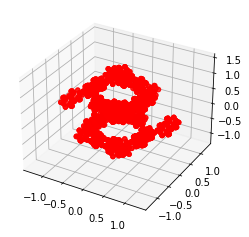

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(ee_point)[:,0], np.array(ee_point)[:,1], np.array(ee_point)[:,2], zdir='z', c= 'red')